In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


# Appending python modules so we can run simulations
sys.path.append("../python")
from utility import load_scene
from pymunk.vec2d import Vec2d

# Import new data

In [35]:
data_path = "../experiments/experiment8/data/data.csv"

data = pd.read_csv(data_path)
data['experiment_version'] = 4

# Removing unused columns from jsPsych
data = data.drop(columns=['success','failed_images','failed_audio',
                          'failed_video','time_elapsed','scene_sp',
                          'internal_node_id','session_id','study_id',
                          'value','stimulus','timeout',
                          'trial_type'])

# Copy dataframe
responses = data
# Remove attempts column since we no longer are using it
responses = responses.drop(columns=['attempts'])
# Convert all scene type entries to strings
responses.scene_type = responses.scene_type.astype(str)
# Retain only the scene type (remove "_goalpos_" substring)
responses.scene_type = responses.scene_type.apply(lambda x: "_".join(x.split('_')[:2]))
# Convert all scene entries to strings
responses.scene = responses.scene.astype(str)
# Retain only the scene name (remove ".mp4" substring)
responses.scene = responses.scene.apply(lambda x: x.split('.')[0])
# Remove all tasks that aren't coded as response
responses = responses.loc[(responses.task == 'response')]
# Remove the task column since we no longer are using it
responses = responses.drop(columns=['task'])
# Calculate variable-wise z-scores for response time
responses['var_zrt'] = responses.groupby('experiment_version').rt.apply(lambda x: (x-x.mean()) / x.std())
# Calculate participant-wise z-score for response time
responses['part_zrt'] = responses.groupby(['experiment_version','subject_id']).rt.apply(lambda x: (x-x.mean()) / x.std())
# Check these z-scores are not equivalent
all(responses['var_zrt'] == responses['part_zrt'])
# sns.scatterplot(x="var_zrt",y="part_zrt", data=responses) # Should be a straight line if they're the same
# Determine number of datapoints lost by outlier exclusion
excluded = len(responses) - len(responses[abs(responses.part_zrt) <= 2])
print(f"{excluded} of {len(responses)} ({excluded/len(responses)*100:.4}%) are excluded via 2-SD exclusion")

# Excluding outliers
responses = responses[abs(responses.part_zrt) <= 2]

3227 of 87120 (3.704%) are excluded via 2-SD exclusion


In [36]:
loaddir = "../data/json/pilot8/trial/"
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

# Dictionary that will contain distance travelled per scenario 
distances = []

# Iterate through stimuli files
for scene_json in json_files:
    scene_dir = loaddir+scene_json
    scene_name = get_scene_name(scene_json)
    if 'negative' in scene_name:
        collision = False
    else:
        collision = True
    scene = load_scene(scene_dir)
    # Extract the origin (the ball's starting position)
    origin = scene.args['ball_args'][0]
    # Extract the goal position
    goal = scene.args['goal_args'][0]
    # Convert these points into Vec2d for compatibility with pymunk
    origin = Vec2d(*origin)
    goal = Vec2d(*goal)
    dist = {}
    # Compute the distance
    dist['distance'] = origin.get_distance(goal)
    # Add the scene, distance pair into the dataframe
    dist['scene'] = scene_name
    dist['collision'] = collision
    distances.append(dist)
    
distances = pd.DataFrame.from_dict(distances)

distances['distance'] = distances['distance'].apply(int)

In [37]:
responses = responses.merge(distances, on="scene")

In [38]:
responses.to_json('experiment_4_data.json')

# Helpers

In [39]:
def get_scene_name(file_name):
    '''
    Returns scene name from file name
    '''
    return file_name.split(".")[0]

def get_scene_type(scene_name):
    '''
    Returns the scene type for a given scene name.
    '''
    split_name = scene_name.split('_')[:2]
    return '_'.join(split_name)

# Demo

In [40]:
data_path_exp3 = "experiment_4_data.json"
data_exp3 = pd.read_json(data_path_exp3)

In [47]:
print(f'{len(set(data_exp3.subject_id))} participants')

315 participants


In [48]:
# Number of participants per conditions
data_exp3.groupby(['scene_type','collision']).subject_id.apply(lambda x: len(set(x)))

scene_type  collision
stim_2      False        102
            True         102
stim_4      False        109
            True         109
stim_6      False        106
            True         106
Name: subject_id, dtype: int64

In [50]:
# Only including participants who are correct
b = len(data_exp3)
data_exp3 = data_exp3.loc[data_exp3.correct]
a = len(data_exp3)

print(f'{(b-a)/b*100}% of responses removed')

0.0% of responses removed


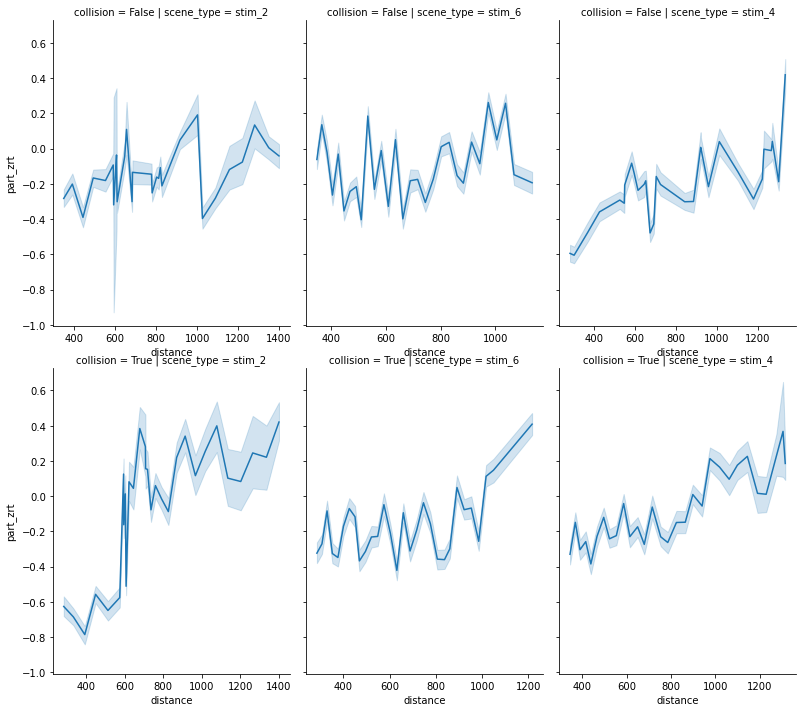

In [46]:
g = sns.relplot(
    data=data_exp3,
    x="distance", y="part_zrt", 
    col="scene_type", row="collision",
    kind="line",
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

g.savefig('accuracy_output.pdf')

## Within vs between subjects variance

Check variance within participants for each scene, across the n samples and make sure the step is smaller than the noise levels.

This will also help us determine 

In [90]:
scene2data = data_exp3.loc[(data_exp3['scene_type'] == 'stim_2') & (data_exp3['collision'] == True)]

In [91]:
scene2data['repetition'] = scene2data.groupby('subject_id').cumcount().astype(str)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_79601/1151724925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scene2data['repetition'] = scene2data.groupby('subject_id').cumcount().astype(str)


In [92]:
scene2data = scene2data[['rt','distance','repetition','subject_id']]

In [114]:
# Compute the variance in rt for each subject's set of responses per distance
var_per_distance_per_sub = scene2data.groupby(['subject_id','distance']).var()

In [115]:
# Compute the mean of the rt variances per subject per distance
within_sub_var = var_per_distance_per_sub.mean()

In [116]:
# Compute the mean rt for each subject's set of responses per distance
mean_var_per_distance = var_per_distance_per_sub.groupby(['subject_id','distance']).mean()

In [117]:
# Compute the variances in mean rts for each distance
var_per_distance = mean_per_distance.groupby('distance').var()

In [122]:
# Compute the mean variance in rt across distances
between_sub_var = var_per_distance.mean()

In [123]:
within_sub_var

rt    296735.05837
dtype: float64

In [124]:
between_sub_var

rt    3.625460e+12
dtype: float64

# Smoothing

In [51]:
import numpy as np
import matplotlib.pyplot as plt

<BarContainer object of 40 artists>

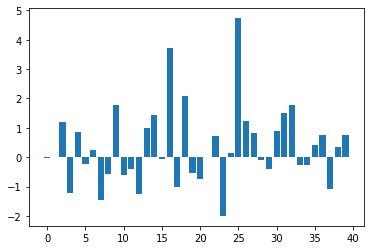

In [52]:
n_points = 40
x_vals = np.arange(n_points)
y_vals = np.random.normal(size=n_points)
plt.bar(x_vals, y_vals)

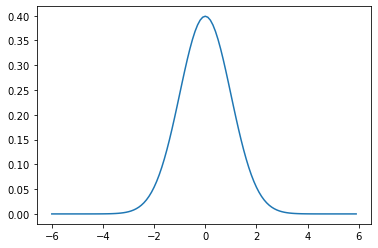

In [53]:
x = np.arange(-6,6,0.1)
y = 1 / np.sqrt(2 * np.pi) * np.exp(-x ** 2/2.)
plt.plot(x,y)

In [54]:
def sigma2fwhm(sigma):
    return sigma * np.sqrt(8 * np.log(2))

In [55]:
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

<BarContainer object of 40 artists>

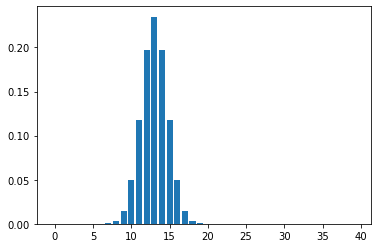

In [56]:
FWHM = 4
sigma = fwhm2sigma(FWHM)
x_position = 13
kernel_at_pos = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
kernel_at_pos = kernel_at_pos / sum(kernel_at_pos)
plt.bar(x_vals, kernel_at_pos)

In [57]:
kernel_at_pos[11:16]

array([0.11742966, 0.19749236, 0.23485932, 0.19749236, 0.11742966])

In [58]:
y_vals[11:16]

array([-0.40531441, -1.24796164,  0.99575378,  1.43205678, -0.07677702])

In [60]:
y_by_weight = y_vals * kernel_at_pos

In [61]:
new_val = sum(y_by_weight)

In [62]:
new_val

0.382378609732717

<BarContainer object of 40 artists>

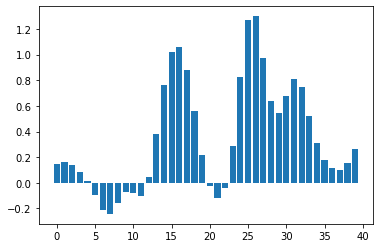

In [63]:
smoothed_vals = np.zeros(y_vals.shape)
for x_position in x_vals:
    kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_vals[x_position] = sum(y_vals * kernel)
plt.bar(x_vals, smoothed_vals)

In [66]:
len(y_vals)

40

In [67]:
len(smoothed_vals)

40

In [75]:
x_vals = np.array(data_exp3.distance)

In [76]:
y_vals = np.array(data_exp3.part_zrt)

In [78]:
smoothed_vals = np.zeros(y_vals.shape)
for x_position in x_vals:
    kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_vals[x_position] = sum(y_vals * kernel)

In [79]:
len(smoothed_vals)

66079

In [80]:
data = pd.DataFrame({"distance":x_vals, ""})

66079

In [83]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.datasets import make_regression
import numpy as np

# dummy data:
X, y = make_regression(n_samples=20, n_features=5, n_targets=1)

# (20, 5)

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)
# GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
#             kernel=RBF((length_scale=1), n_restarts_optimizer=0,
#             normalize_y=False, optimizer='fmin_l_bfgs_b',
#             random_state=None)

array([0., 0., 0., ..., 0., 0., 0.])

In [132]:
y_vals = data_exp3.groupby('subject_id').part_zrt.apply(np.array)
y_vals

subject_id
577cc873092b09000179c3e6    [-0.32742296, 1.4215485519, -0.405555708, 0.38...
5865dd647fbbcd00013973b8    [0.1411385308, 0.22060655980000002, 0.14113853...
58b718c7e38022000152c828    [1.1282772017, -0.2386106829, 0.39954480540000...
58f93198dbfafa0001d227c9    [0.2919379503, 0.2919379503, -1.4091575513, -1...
5a7659fd8fe2dc00010573be    [-0.1105686352, -0.4138312797, -0.6873622924, ...
                                                  ...                        
624e10e161a702342a781a11    [-0.2069294683, 0.23702527680000002, -0.241847...
63065979b2924e563b2fcd4a    [-1.0809265966, -1.0809265966, -0.2122502899, ...
63065b27cb33913a4c7a11f6    [-0.5633581837, 0.1490447285, -0.8135679870000...
63164797edf52e6db52f066a    [-0.48763589999999996, -0.2189002484, -0.36030...
636546d0648b922d14056683    [0.37923024520000004, -1.1436819906, -1.410859...
Name: part_zrt, Length: 315, dtype: object

In [131]:
y_vals = [l for l in y_vals]
y_vals.shape

AttributeError: 'list' object has no attribute 'shape'

In [133]:
x = np.concatenate(y_vals, axis=0)

In [134]:
x.shape

(66079,)